In [1]:
import pandas as pd 
import numpy as np
from numpy import absolute
import xgboost
from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import shap
import matplotlib.pyplot as plt


2022-02-13 21:11:19.707004: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /anaconda/envs/azureml_py38/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-13 21:11:19.707057: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# _________________read train dataset_______________#
df_raw = pd.read_csv('train_0OECtn8.csv')

# _________________read test________________________# 
df_test_raw = pd.read_csv('test_1zqHu22.csv')


In [3]:
df_raw.describe()

,row_id,user_id,category_id,video_id,age,followers,views,engagement_score
count,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000
mean,44599.000000,13881.909806,18.323733,77.715383,24.848616,252.460172,502.980268,3.487797
std,25749.100318,8005.582771,11.675154,48.469656,8.955535,46.094468,268.569482,0.863498
min,1.000000,1.000000,1.000000,1.000000,10.000000,160.000000,30.000000,0.000000
25%,22300.000000,6945.000000,8.000000,34.000000,18.000000,230.000000,229.000000,2.900000
50%,44599.000000,13892.000000,16.000000,76.000000,23.000000,240.000000,467.000000,3.710000
75%,66898.000000,20819.000000,26.000000,120.000000,32.000000,280.000000,714.000000,4.150000
max,89197.000000,27734.000000,47.000000,175.000000,68.000000,360.000000,1000.000000,5.000000


In [4]:
# df_raw.corr()

In [5]:
df_raw.columns

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score'],
      dtype='object')

In [6]:
# EDA
#     Groupby age on engagement score
# df_ae = df_raw.groupby('age')['engagement_score'].agg([percentile(75)]).reset_index()
# df_ae.percentile_75.plot()

# check if any user_id is not present in the inference 
# list(set(df_test['user_id'])- set(df_raw['user_id']) )

In [7]:
def cap_outliers(series, iqr_threshold=1.5, verbose=False):
    '''Caps outliers to closest existing value within threshold (IQR).
    Args: Series, iqr threshold, verbose
    Return: Capped series'''
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lbound = Q1 - iqr_threshold * IQR
    ubound = Q3 + iqr_threshold * IQR

    outliers = (series < lbound) | (series > ubound)

    series = series.copy()
    series.loc[series < lbound] = series.loc[~outliers].min()
    series.loc[series > ubound] = series.loc[~outliers].max()

    # For comparison purposes.
    if verbose:
            print('\n'.join(
                ['Capping outliers by the IQR method:',
                 f'   IQR threshold: {iqr_threshold}',
                 f'   Lower bound: {lbound}',
                 f'   Upper bound: {ubound}\n']))

    return series

def pd_mode(x):
    '''args: pandas series
     Return: Mode of a series'''
    m = pd.Series.mode(x);
    return m.values[0] if not m.empty else np.nan

def percentile(n):
    '''args: pandas series 
     return: nth percentile of series '''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [8]:
def clean_inf(df, df_va, df_ua, df_aa, iqr_threshold):
    '''
    args: DataFrame, merge_dfs
    Return: cleaned dataframe (Label encoded & feature eng)  
    '''
    le_gender=LabelEncoder()
    df['gender']=le_gender.fit_transform(df['gender'])
    
    le_profession=LabelEncoder()
    df['profession']=le_profession.fit_transform(df['profession'])
    
    df['followers'] = cap_outliers(df['followers'],iqr_threshold=iqr_threshold)
    df['views'] = cap_outliers(df['views'],iqr_threshold=iqr_threshold)
    

#     merge train df_va, df_ua, df_aa with DF
    df = df.merge(df_va, how='left', on= 'video_id')
    df = df.merge(df_ua, how='left', on= 'user_id')
    df = df.merge(df_aa, how='left', on= 'age') 
    
    return df 

In [9]:
df_raw.columns

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'gender',
       'profession', 'followers', 'views', 'engagement_score'],
      dtype='object')

In [10]:
def clean_train(df,iqr_threshold):
    '''args: DataFrame
    return: cleaned dataframe, to be merged train dataframes'''
    
#__________________________label encode________________________
# _______________________________________________________________
    le_gender=LabelEncoder()
    df['gender']=le_gender.fit_transform(df['gender'])

    le_profession=LabelEncoder()
    df['profession']=le_profession.fit_transform(df['profession'])

    df['followers'] = cap_outliers(df['followers'],iqr_threshold=iqr_threshold)
    df['views'] = cap_outliers(df['views'],iqr_threshold=iqr_threshold)

# _________________________AGG Video ID___________________________#
# __________________________________________________________________
#     Groupby video_id on engagement score 
    df_va = df.groupby('video_id')['engagement_score'].agg(['mean']) \
            .rename(columns={'mean':'video_id'+'_'+'engagement_score'+'_mean'}).reset_index()
    df = df.merge(df_va, how='left', on= 'video_id')
    
    
# _________________________AGG User ID___________________________#
# __________________________________________________________________
#     Groupby user_id on engagement score
    df_ue = df.groupby('user_id')['engagement_score'].agg(['mean']) \
            .rename(columns={'mean':'user_id'+'_'+'engagement_score'+'_mean'}).reset_index()
    df = df.merge(df_ue, how='left', on= 'user_id')
    
#     Groupby user_id on video_ID
    df_uvi = df.groupby('user_id')['video_id'].agg([pd_mode]) \
            .rename(columns={'pd_mode':'user_id'+'_'+'video_id'+'_pd_mode'}).reset_index()
    df = df.merge(df_uvi, how='left', on= 'user_id')
    
    
#     Groupby user_id on category_id
    df_uc = df.groupby('user_id')['category_id'].agg(['mean']) \
            .rename(columns={'mean':'user_id'+'_'+'category_id'+'_mean'}).reset_index()
    df = df.merge(df_uc, how='left', on= 'user_id')
    
#     Groupby user_id on views
    df_uv = df.groupby('user_id')['views'].agg(['mean']) \
            .rename(columns={'mean':'user_id'+'_'+'views'+'_mean'}).reset_index()
    df = df.merge(df_uv, how='left', on= 'user_id')
    
# #     Groupby user_id on followers
#     df_uf = df.groupby('user_id')['followers'].agg(['mean']) \
#             .rename(columns={'mean':'user_id'+'_'+'followers'+'_mean'}).reset_index()
#     df = df.merge(df_uf, how='left', on= 'user_id')
    
    
#     _________merge all user_id agg (ue, uc, uv, uvi)_________
    df_ua = df_ue.merge(df_uc, how='left', on= 'user_id')\
                 .merge(df_uv, how='left', on= 'user_id')\
                 .merge(df_uvi, how='left', on= 'user_id')\
#                  .merge(df_uf, how='left', on= 'user_id')
    
# _________________________AGG age__________________________#
# __________________________________________________________________
#     Groupby age on engagement score
    df_aa = df.groupby('age')['engagement_score'].agg(['mean']) \
            .rename(columns={'mean':'age'+'_'+'engagement_score'+'_mean'}).reset_index()
    df = df.merge(df_aa, how='left', on= ['age'])
    

    
    return df, df_va, df_ua, df_aa

In [11]:
feature_rejected = ['user_id','video_id', 'age']

def train_preprocessing(df_raw, iqr_threshold):
    '''args: DataFrame,
       return: preprocessed df, to be merged train dataframe, scaler '''
    df = df_raw.copy().drop(columns=['row_id'])
    

    
#     ____________Clean and feature engineer______________    #
    df, df_va, df_ua, df_aa = clean_train(df, iqr_threshold=iqr_threshold)
    
    X, y = df.drop(columns=['engagement_score']), df_raw['engagement_score']
    
    
#     ______________Standard scaler_________________   #

    scaler = StandardScaler().fit(X)
    
    X = pd.DataFrame(scaler.transform(X),columns = X.columns)
    
    
    return X.drop(columns=feature_rejected), y, df_va, df_ua, df_aa, scaler


# ____________________________________Inf Preprocessing_________________________________________
def inf_preprocessing(df_test_,df_va, df_ua, df_aa, scaler, iqr_threshold):
    '''args: DataFrame, to be merged dataframe from train
    return: preprocessed df'''
    
    df = df_test_.copy().drop(columns=['row_id'])

    
#     ____________Clean and feature engineer______________    #
    X = clean_inf(df, df_va, df_ua, df_aa, iqr_threshold=iqr_threshold)
    

    print(list(X.columns))
#     ____________Standard scaler Transform________________   #
    X = pd.DataFrame(scaler.transform(X),columns = X.columns)
    
    
    
    X = X.drop(columns=feature_rejected)
    
    return X

In [12]:
# ___________________preprocessing____________________#
# ______________________________________________________________________________#
iqr_threshold=6
X, y, df_va, df_ua, df_aa, scaler = train_preprocessing(df_raw,iqr_threshold=iqr_threshold)

# ____________________split data_______________________#
# ______________________________________________________________________________#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training Performance: 0.7116303583820347
MAE 0.3291391419336792
MSE 0.214300981283162
RMSE 0.4629265398345206
RMSE -0.7701868987484672
__________________________test metrics________________________________
Test Performance: 0.7058080575244745
MAE 0.3342117388492008
MSE 0.2222590638411175
RMSE 0.4714435956093979
RMSE -0.7519558116162193
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'video_id_engagement_score_mean', 'user_id_engagement_score_mean', 'user_id_category_id_mean', 'user_id_views_mean', 'user_id_video_id_pd_mode', 'age_engagement_score_mean']


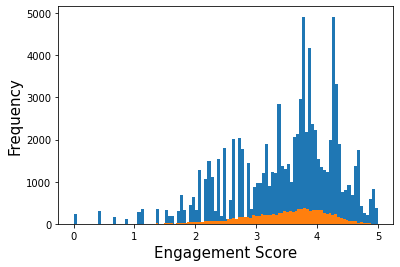

In [15]:
# _______________model train and inferencing____________________#

model = xgboost.XGBRegressor(n_estimators=191, max_depth=7, learning_rate =0.1,
                                 subsample=0.7, colsample_bytree=0.8, gamma=6)


model = model.fit(X_train, y_train)
# model = model.fit(X, y)

predictions_ = model.predict(X_train)
train_score_lr=r2_score(y_train, predictions_)
print(f"Training Performance: {train_score_lr}")
print("MAE",mean_absolute_error(y_train,predictions_))
print("MSE",mean_squared_error(y_train,predictions_))
print("RMSE",np.sqrt(mean_squared_error(y_train,predictions_)))
print("RMSE",np.log(np.sqrt(mean_squared_error(y_train,predictions_))))

print("__________________________test metrics________________________________")
# _____________________evaluate on the test dataset__________________________#
# ______________________________________________________________________________#
predictions = model.predict(X_test)
test_score_lr = r2_score(y_test, predictions)
print(f"Test Performance: {test_score_lr}")
print("MAE",mean_absolute_error(y_test,predictions))
print("MSE",mean_squared_error(y_test,predictions))
print("RMSE",np.sqrt(mean_squared_error(y_test,predictions)))
print("RMSE",np.log(np.sqrt(mean_squared_error(y_test,predictions))))

# _________________inference preprocessing________________________#
df_test = df_test_raw.copy()
test_df = inf_preprocessing(df_test, df_va, df_ua, df_aa, scaler,iqr_threshold=iqr_threshold)

# _________________predict test________________________#
test_score = model.predict(test_df[list(X_train.columns)])

# _________________plot distribution________________________# 
_,_,_ = plt.hist(df_raw['engagement_score'],bins=100)
_,_,_ = plt.hist(test_score,bins=100)
fontsize = 15
plt.xlabel("Engagement Score", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)

# ___________________Save Inference prediction_________________________ 
df_test['engagement_score']=test_score
df_test[['row_id', 'engagement_score']].to_csv("gamma_reg_lambda.csv",index=False)

Training Performance: 0.7122213903809508
Test Performance: 0.7185051168375539
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'video_id_engagement_score_mean', 'user_id_engagement_score_mean', 'user_id_category_id_mean', 'user_id_views_mean', 'user_id_video_id_pd_mode', 'age_engagement_score_mean']
Training Performance: 0.712221326657366
Test Performance: 0.7185032667338929
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'video_id_engagement_score_mean', 'user_id_engagement_score_mean', 'user_id_category_id_mean', 'user_id_views_mean', 'user_id_video_id_pd_mode', 'age_engagement_score_mean']
Training Performance: 0.7122210346780017
Test Performance: 0.7184960846878135
['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'video_id_engagement_score_mean', 'user_id_engagement_score_mean', 'user_id_category_id_mean', 'user_id_views_mean', 'user_id_video_id_pd_mode'

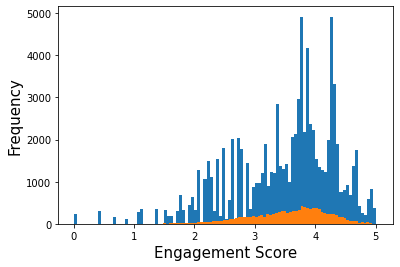

In [110]:
# _____________________hyper parameter tuning__________________________#
# ______________________________________________________________________________#
n_estimators= 190

for n_estimators in [188,189,190,191,192,193]:
    model = xgboost.XGBRegressor(n_estimators=n_estimators, max_depth=7, learning_rate =0.1,
                                 subsample=0.7, colsample_bytree=0.8, gamma=6)


    model = model.fit(X_train, y_train)
    # model = model.fit(X, y)

    train_score_lr=r2_score(y_train, model.predict(X_train))
    print(f"Training Performance: {train_score_lr}")

    # _____________________evaluate on the test dataset__________________________#
    # ______________________________________________________________________________#
    predictions = model.predict(X_test)
    test_score_lr = r2_score(y_test, predictions)
    print(f"Test Performance: {test_score_lr}")

    # _________________inference preprocessing________________________#
    df_test = df_test_raw.copy()
    test_df = inf_preprocessing(df_test, df_va, df_ua, df_aa, scaler,iqr_threshold=iqr_threshold)

    # _________________predict test________________________#
    test_score = model.predict(test_df[list(X_train.columns)])

    # _________________plot distribution________________________# 
    _,_,_ = plt.hist(df_raw['engagement_score'],bins=100)
    _,_,_ = plt.hist(test_score,bins=100)
    fontsize = 15
    plt.xlabel("Engagement Score", fontsize=fontsize)
    plt.ylabel("Frequency", fontsize=fontsize)

    # ___________________Save Inference prediction_________________________ 
    df_test['engagement_score']=test_score
    df_test[['row_id', 'engagement_score']].to_csv(str(n_estimators)+"n_estimators.csv",index=False)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [7,],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5],
    "n_estimators":[190,],
    "learning_rate":[0.1,],
    "subsample":[0.7,],
    "colsample_bytree":[0.8,]
    
}
grid_cv = GridSearchCV(xgboost.XGBRegressor(), param_grid, scoring="r2", n_jobs=-1, cv=3).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train r2 Score for GS: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test r2 Score for GS: ", r2_score(y_test, grid_cv.predict(X_test)))

['user_id', 'category_id', 'video_id', 'age', 'gender', 'profession', 'followers', 'views', 'video_id_engagement_score_mean', 'user_id_engagement_score_mean', 'user_id_category_id_mean', 'user_id_views_mean', 'user_id_video_id_pd_mode', 'age_engagement_score_mean']


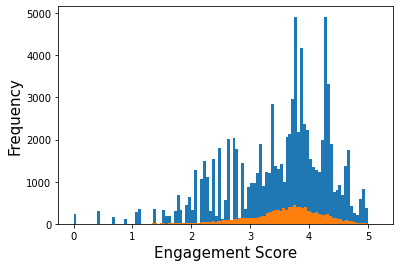

In [87]:
X_train.columns

Index(['category_id', 'gender', 'profession', 'followers', 'views',
       'video_id_engagement_score_mean', 'user_id_engagement_score_mean',
       'user_id_video_id_pd_mode', 'user_id_category_id_mean',
       'user_id_views_mean', 'age_engagement_score_mean'],
      dtype='object')

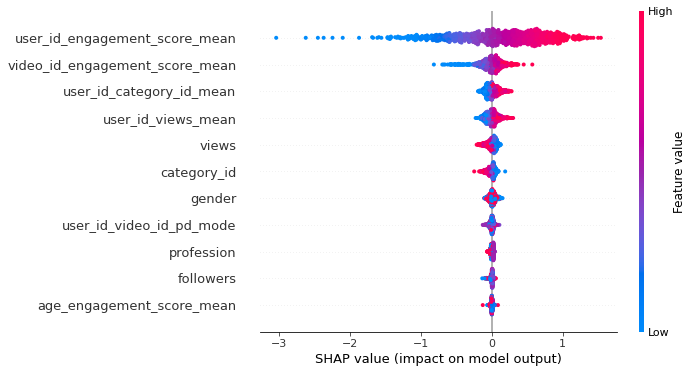

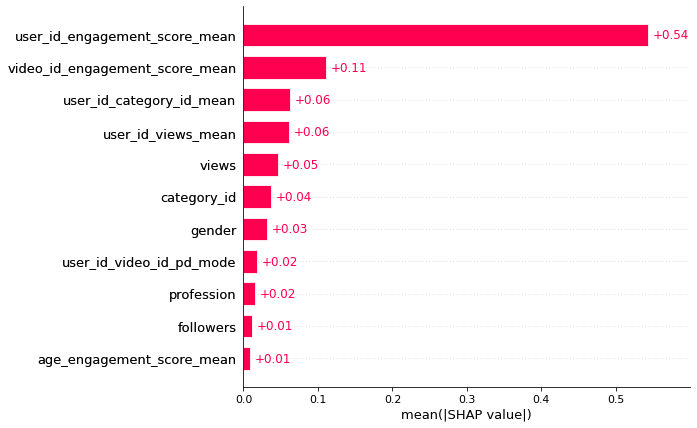

In [86]:
# ______________compute SHAP values__________________
# _____________________________________________________
explainer = shap.Explainer(model, X_train[::100])
shap_values = explainer(X_train[::100])
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.bar(shap_values.abs.mean(0),max_display=20)

In [67]:
# ________Feature selection using sklearn SelectFromModel________
# ________________________________________________________________

from sklearn.feature_selection import SelectFromModel

# Fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    print(thresh)
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgboost.XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    r2 = r2_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, r2: %.3f%%" % (thresh, select_X_train.shape[1], r2*100.0))

0.016565595
Thresh=0.017, n=12, r2: 71.663%
0.01895317
Thresh=0.019, n=11, r2: 72.124%
0.02249455
Thresh=0.022, n=10, r2: 72.316%
0.02261055
Thresh=0.023, n=9, r2: 71.634%
0.022833703
Thresh=0.023, n=8, r2: 72.319%
0.023157513
Thresh=0.023, n=7, r2: 72.139%
0.029494468
Thresh=0.029, n=6, r2: 70.675%
0.03664302
Thresh=0.037, n=5, r2: 70.532%
0.056776814
Thresh=0.057, n=4, r2: 71.283%
0.060148127
Thresh=0.060, n=3, r2: 62.519%
0.07135596
Thresh=0.071, n=2, r2: 63.570%
0.6189666
Thresh=0.619, n=1, r2: 64.303%


In [60]:
# ________Feature selection using sklearn SelectFromModel________

thresh=0.021527847
# select features using threshold
selection = SelectFromModel(model, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = xgboost.XGBRegressor()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
predictions = selection_model.predict(select_X_test)
r2 = r2_score(y_test, predictions)
print("Thresh=%.3f, n=%d, r2: %.3f%%" % (thresh, select_X_train.shape[1], r2*100.0))

feature_idx = selection.get_support()
feature_name = X_train.columns[feature_idx]
list(set(X_train.columns) - set(feature_name))

Thresh=0.022, n=10, r2: 72.541%


['age_engagement_score_mean', 'cust_type']